In [76]:
import torch
import shutil
import numpy as np
import pandas as pd
import urllib.request
import seaborn as sns
import matplotlib.pyplot as plt

In [77]:
url = "http://mde-lab.aegean.gr/images/stories/docs/smear2005.zip"
filename = "data.zip"

In [78]:
with urllib.request.urlopen(url) as response, open(filename, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)

In [79]:
!unzip -qq data.zip

replace smear2005/B22b_p_Jantzen.pdf? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [80]:
df = pd.read_excel('./smear2005/new_database_results.xls')

In [81]:
df.describe()

,Kerne_A,Cyto_A,K/C,Kerne_Ycol,Cyto_Ycol,KerneShort,KerneLong,KerneElong,KerneRund,CytoShort,CytoLong,CytoElong,CytoRund,KernePeri,CytoPeri,KernePos,KerneMax,KerneMin,CytoMax,CytoMin,Class
count,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000
mean,2990.826881,14053.904444,0.356610,90.490139,139.356935,52.497274,71.193455,0.750395,0.705578,118.130049,171.596531,0.691923,0.381297,201.161396,490.032579,0.274383,107.895311,86.651036,416.865867,423.703381,4.577972
std,1878.177267,20357.674179,0.213364,21.780290,25.012857,18.754784,23.242059,0.156531,0.154648,71.904552,90.183748,0.177367,0.172679,67.798197,274.857442,0.165056,57.507109,54.833614,633.817458,621.690605,1.816252
min,316.875000,467.875000,0.003990,17.913947,69.889702,13.973914,19.416488,0.307806,0.270610,29.457850,44.643029,0.210975,0.066993,60.750000,136.125000,0.003364,19.000000,13.000000,14.000000,21.000000,1.000000
25%,1599.750000,2329.000000,0.218484,76.017591,123.257682,38.929320,55.713553,0.642667,0.598836,67.732383,104.235311,0.567724,0.251712,154.250000,287.375000,0.149395,67.000000,49.000000,71.000000,85.000000,3.000000
50%,2592.250000,4891.250000,0.354828,89.201813,138.402393,50.404684,71.175839,0.762162,0.716932,93.126177,142.579802,0.696390,0.350568,199.500000,388.125000,0.242546,96.000000,74.000000,140.000000,155.000000,5.000000
75%,3976.000000,14019.875000,0.504971,103.399375,151.040909,64.771793,86.353923,0.859482,0.813543,144.291619,215.058132,0.807432,0.495136,243.375000,608.750000,0.364968,134.000000,109.000000,398.000000,421.000000,6.000000
max,10794.625000,127313.750000,0.885497,174.994651,230.486399,112.723053,158.823802,1.192308,1.135615,418.494540,571.909084,1.215871,1.071126,411.375000,1718.000000,0.903233,430.000000,432.000000,3906.000000,4000.000000,7.000000


## Pytorch

In [83]:
a = torch.ones(5)
b = torch.ones(5)

c = a + b

print(c)

tensor([2., 2., 2., 2., 2.])


In [84]:
a = torch.ones(5, requires_grad=True)
b = torch.randn(5, requires_grad=True)

c = torch.matmul(a, b)

print(a, '\n', b, '\n', c)

tensor([1., 1., 1., 1., 1.], requires_grad=True) 
 tensor([-0.1361, -0.6721, -0.3043, -0.6361,  0.0797], requires_grad=True) 
 tensor(-1.6690, grad_fn=<DotBackward0>)


$$c = \mathbf{a}^{T}\mathbf{b}$$

$$\nabla_{\mathbf{a}}c = \mathbf{b}$$

$$\nabla_{\mathbf{b}}c = \mathbf{a}$$

In [85]:
torch.autograd.grad(outputs=c, inputs=a)

(tensor([-0.1361, -0.6721, -0.3043, -0.6361,  0.0797]),)

In [86]:
c = torch.matmul(a, b)

print(a, '\n', b, '\n', c)

tensor([1., 1., 1., 1., 1.], requires_grad=True) 
 tensor([-0.1361, -0.6721, -0.3043, -0.6361,  0.0797], requires_grad=True) 
 tensor(-1.6690, grad_fn=<DotBackward0>)


In [87]:
torch.autograd.grad(outputs=c, inputs=b)

(tensor([1., 1., 1., 1., 1.]),)

## Trazendo dados Pandas => Numpy

In [88]:
X = df.values[:, 1:-1]
y = df.values[:, -1]

y = 1 * (y >= 4)

### Dividindo entre treino e teste

In [89]:
ind_0 = np.where(y == 0)[0]
ind_1 = np.where(y == 1)[0]

np.random.shuffle(ind_0), np.random.shuffle(ind_1)

print(len(ind_0), len(ind_1))

242 675


In [90]:
ind_tr = np.concatenate([
    ind_0[:int(0.8 * len(ind_0))], 
    ind_1[:int(0.8 * len(ind_1))]
])

ind_ts = np.concatenate([
    ind_0[int(0.8 * len(ind_0)):], 
    ind_1[int(0.8 * len(ind_1)):]
])

np.random.shuffle(ind_tr), np.random.shuffle(ind_ts)

(None, None)

### Normalizando os dados

In [91]:
Xtr, ytr = X[ind_tr, :], y[ind_tr]
Xtr = (Xtr - Xtr.min(axis=0)) / (Xtr.max(axis=0) - Xtr.min(axis=0))

Xts, yts = X[ind_ts, :], y[ind_ts]
Xts = (Xts - Xts.min(axis=0)) / (Xts.max(axis=0) - Xts.min(axis=0))

## Trazendo os dados para o Pytorch

In [92]:
Xtr, ytr = torch.from_numpy(Xtr.astype(float)).float(), torch.from_numpy(ytr.astype(float)).float()
Xts, yts = torch.from_numpy(Xts.astype(float)).float(), torch.from_numpy(yts.astype(float)).float()

## Criando o modelo

In [93]:
# Valores iniciais
theta = 0.01 * torch.randn(20, 1, requires_grad=True)
b = 0.01 * torch.randn(1, 1, requires_grad=True)

### Predição

$$\text{logit}\, p = \theta^{T}\mathbf{x}+b$$

$$p = \dfrac{1}{1+e^{-\theta^{T}\mathbf{x}-b}} = \sigma(\mathbf{x})$$

In [94]:
# Calculo do logit
logit = torch.add(torch.matmul(Xtr, theta), b)
# Cálculo da prob. P(Y=1|X)
# OBS: função sigmóide
yhat = 1 / (1 + torch.exp(- logit))

### Função de Custo

Temos que maximizar:

$$L(\theta, b) = \dfrac{1}{N}\sum_{i=1}^{N}y_{i}\log\sigma(\mathbf{x}_{i})+(1-y_{i})\log(1-\sigma(\mathbf{x}_{i}))$$

ou... minimizar

$$- L(\theta, b)$$


In [95]:
neg_log_likelihood = - torch.mean(ytr * torch.log(yhat) + (1 - ytr) * torch.log(1 - yhat))

In [96]:
neg_log_likelihood

tensor(0.6930, grad_fn=<NegBackward0>)

In [97]:
gradients = torch.autograd.grad(neg_log_likelihood, inputs=[theta, b])

In [98]:
g_theta, g_b = gradients

## Gradiente Descendente Estocástico

Como estamos __minimizando__

$$\theta^{k+1} = \theta^{k} - \eta\dfrac{\partial \mathcal{L}}{\partial \theta} = \theta^{k} - \eta\dfrac{1}{N}\sum_{i=1}^{N}(y_{i}-\sigma(\mathbf{x}_{i}))\mathbf{x}_{i}$$
$$b^{k+1} = b^{k} - \eta\dfrac{\partial \mathcal{L}}{\partial b} = b^{k} - \eta\dfrac{1}{N}\sum_{i=1}^{N}y_{i}-\sigma(\mathbf{x}_{i})$$

In [99]:
eta = 0.1

In [100]:
theta = theta - eta * g_theta
b = b - eta * g_b

## Juntando tudo...

Questões:

1. Teste diferentes valores de eta ($10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}$)
2. Teste diferentes valores de sigma ($10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}$)

Organize o que você encontrou em dois gráficos

1. Um par de gráficos loss x iteração para cada valor de eta e acc x iteração para cada valor de eta
2. Um par de gráficos loss x iteração para cada valor de eta e acc x iteração para cada valor de sigma (dado o melhor eta, determinado no item anterior).

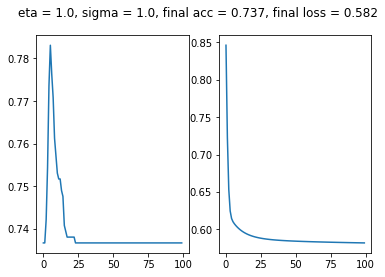

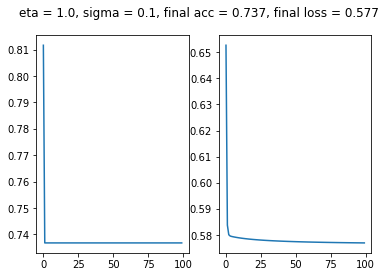

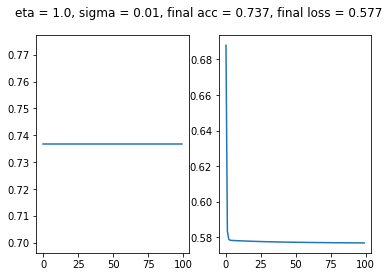

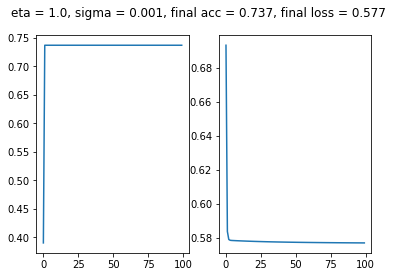

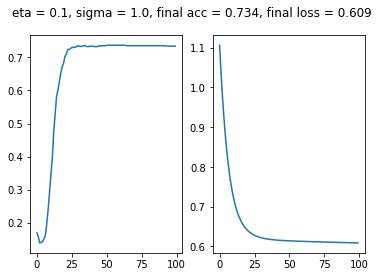

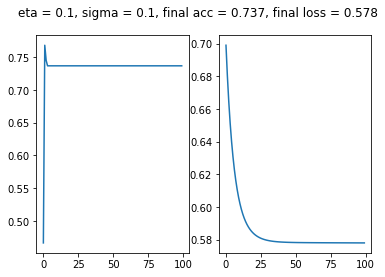

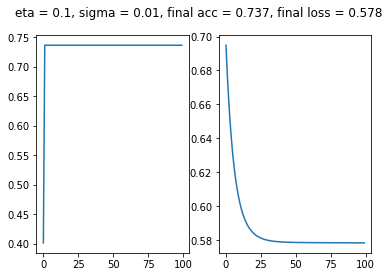

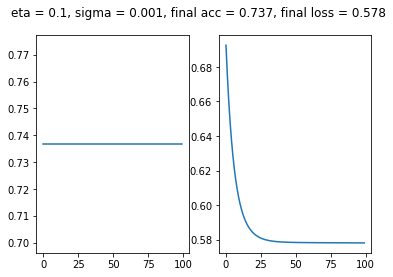

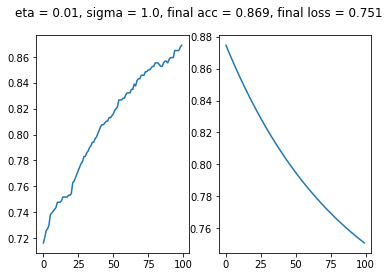

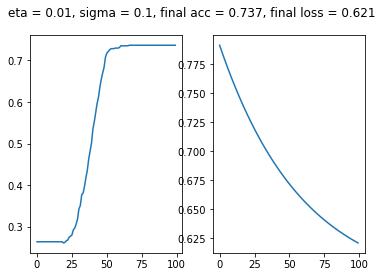

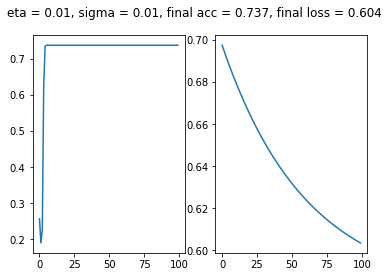

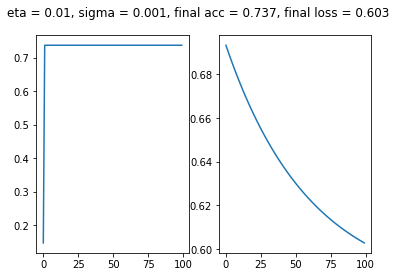

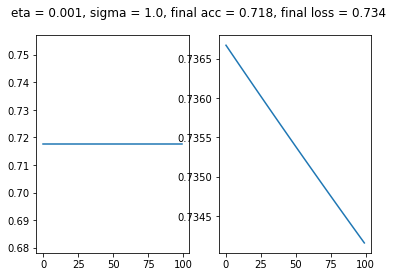

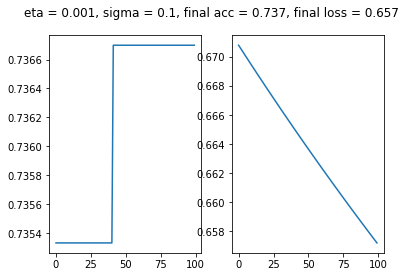

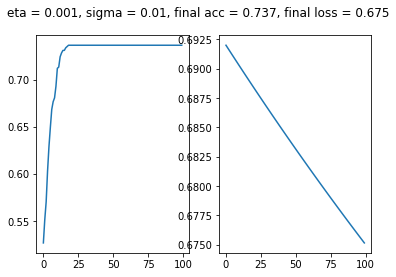

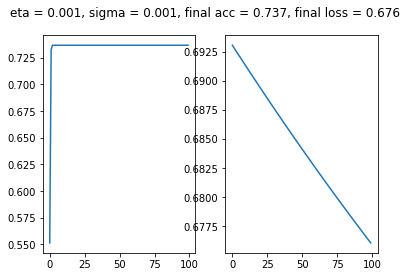

In [101]:
eta_values = [1e-0, 1e-1, 1e-2, 1e-3]
sigma_values = [1e-0, 1e-1, 1e-2, 1e-3]

best_acc = 0
best_loss_history = None
best_acc_history = None
best_eta = None
best_sigma = None

n_iteractions = 100
x_plt = np.linspace(0, n_iteractions-1, n_iteractions, endpoint=True, dtype=int)

for eta in eta_values:
  for sigma in sigma_values:

    theta = sigma * torch.randn(20, 1, requires_grad=True)
    b = sigma * torch.randn(1, 1, requires_grad=True)

    loss_history = []
    acc_history = []

    for k in range(n_iteractions):
        # Calculo do logit
        logit = torch.add(torch.matmul(Xtr, theta), b)
        # Cálculo da prob. P(Y=1|X)
        # OBS: função sigmóide
        # yhat = 1 / (1 + torch.exp(- logit))
        yhat = 1 / (1 + torch.exp(- logit))
        # OBS: yhat >= 0.5 implica que yp = 1
        yp = (1 * (yhat >= 0.5))[:, 0]
        # Excluir o gradiente de yp pois não precisamos dele
        acc = np.sum(1 * (yp.detach().numpy() == ytr.numpy())) / len(ytr)

        # Calculo do neg-log-likelihood
        neg_log_likelihood = - torch.mean(ytr * torch.log(yhat) + (1 - ytr) * torch.log(1 - yhat))

        # Calculo dos gradientes
        gradients = torch.autograd.grad(neg_log_likelihood, inputs=[theta, b])

        # Gradientes
        g_theta, g_b = gradients

        # Atualizar os parâmetros
        theta = theta - eta * g_theta
        b = b - eta * g_b

        # Atualizar histórico
        loss_history.append(neg_log_likelihood)
        acc_history.append(acc)

        # print('It: {}, Loss: {}, Acc: {}'.format(k, neg_log_likelihood, acc))
    
    

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('eta = {}, sigma = {}, final acc = {:.3f}, final loss = {:.3f}'.format(eta, sigma, acc_history[-1], loss_history[-1]))
    ax1.plot(x_plt, acc_history)
    ax2.plot(x_plt, loss_history)
        
    if acc_history[-1] > best_acc:
      best_acc = acc_history[-1]
      best_eta = eta
      best_sigma = sigma
      best_acc_history = acc_history
      best_loss_history = loss_history

In [102]:
print('\nmelhor combinação: eta = {}; sigma = {}'.format(eta, sigma))


melhor combinação: eta = 0.001; sigma = 0.001


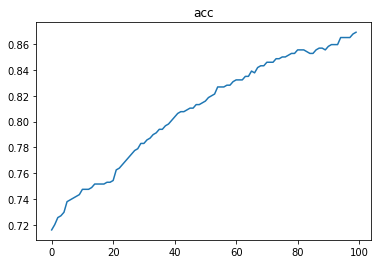

In [103]:
plt.title('acc')
plt.plot(x_plt,best_acc_history)

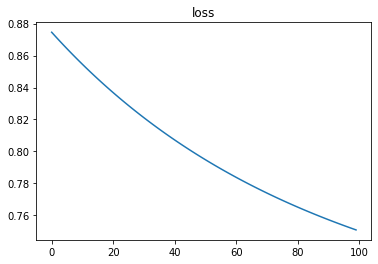

In [104]:
plt.title('loss')
plt.plot(x_plt,best_loss_history)

# Segunda Estratégia

In [105]:
class LogisticRegression(torch.nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        
        # input (N, p), p = 20 => output (N, 1)
        # output = theta^T input + b
        self.layer1 = torch.nn.Linear(20, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        logit = self.layer1(x)
        yhat = self.sigmoid(logit)

        return yhat

In [106]:
model = LogisticRegression()

In [107]:
params = [p for p in model.parameters()]

In [108]:
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [109]:
n_epochs = 100

for epoch in range(n_epochs):
    # Zera os gradientes
    optimizer.zero_grad()

    # Forward Pass
    yhat = model.forward(Xtr)
    ypred = 1 * (yhat.squeeze().detach().numpy() >= 0.5)

    # Loss
    loss = loss_fn(yhat.squeeze(), ytr)

    # Cálculo dos gradientes
    loss.backward()

    # Passo de otimização
    # atualiza os pesos
    optimizer.step()

    # Informações de treinamento
    loss_val = loss.item()
    acc = np.sum(1 * (ypred == ytr.numpy())) / len(ytr)
    print('Loss: {}, Acc: {}'.format(loss_val, acc))

Loss: 0.8289734721183777, Acc: 0.26330150068212826
Loss: 0.8027973175048828, Acc: 0.26330150068212826
Loss: 0.7778567671775818, Acc: 0.2660300136425648
Loss: 0.7541189193725586, Acc: 0.27012278308321963
Loss: 0.7315925359725952, Acc: 0.2837653478854025
Loss: 0.7102938294410706, Acc: 0.32878581173260574
Loss: 0.6902329921722412, Acc: 0.42837653478854026
Loss: 0.671412467956543, Acc: 0.6589358799454298
Loss: 0.6538256406784058, Acc: 0.8281036834924966
Loss: 0.637457013130188, Acc: 0.8485675306957708
Loss: 0.6222817897796631, Acc: 0.8281036834924966
Loss: 0.6082653999328613, Acc: 0.7953615279672579
Loss: 0.5953646302223206, Acc: 0.781718963165075
Loss: 0.5835275650024414, Acc: 0.7680763983628922
Loss: 0.5726948976516724, Acc: 0.7517053206002728
Loss: 0.5628008246421814, Acc: 0.7489768076398363
Loss: 0.5537747740745544, Acc: 0.7462482946793997
Loss: 0.5455428957939148, Acc: 0.7421555252387448
Loss: 0.5380293726921082, Acc: 0.7421555252387448
Loss: 0.5311591029167175, Acc: 0.740791268758526

## Questão

Implementar Regressão Logística Multiclasse usando a aula 4.2.

[Documentação do Pytorch](https://pytorch.org/docs/)

__Dicas:__

1. mude nn.Linear de (20, 1) para (20, K), onde K é o número de classes.
2. mude a ativação para softmax (qual a função em Pytorch?)
3. É preciso mudar a loss function? Note: BCELoss só funciona para saídas BINARY.

# Regressão Logística Multiclasse

In [208]:
from sklearn.model_selection import train_test_split

X = df.values[:, 1:-1]
y = df.values[:,-1] - 1

Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.2, random_state=42)


Xtr = (Xtr - Xtr.min(axis=0)) / (Xtr.max(axis=0) - Xtr.min(axis=0))

Xts = (Xts - Xts.min(axis=0)) / (Xts.max(axis=0) - Xts.min(axis=0))

Xtr, ytr = torch.from_numpy(Xtr.astype(float)).float(), torch.from_numpy(ytr.astype(float)).float()
Xts, yts = torch.from_numpy(Xts.astype(float)).float(), torch.from_numpy(yts.astype(float)).float()

In [209]:
class LogisticRegression(torch.nn.Module):
  def __init__(self):
    super(LogisticRegression, self).__init__()
    self.layer1 = torch.nn.Linear(20, 7)
    self.softmax = torch.nn.Softmax(dim=1)
  
  def forward(self, x):
    logit = self.layer1(x)
    yhat = self.softmax(logit)
    return yhat

In [112]:
# criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
# ytr = torch.nn.functional.one_hot(ytr, num_classes=7)

In [216]:
model = LogisticRegression()

In [211]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [244]:
model = LogisticRegression()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

loss_history = []
acc_history = []

n_epochs = 1000
for epoch in range(n_epochs):
  optimizer.zero_grad()
  # Forward Pass
  yhat = model.forward(Xtr)
  ypred = torch.argmax(yhat.detach(), 1).numpy()
  # Loss
  loss = loss_fn(yhat, ytr.long())
  # Cálculo dos gradientes
  loss.backward()
  # Passo de otimização
  # atualiza os pesos
  optimizer.step()
  # Informações de treinamento
  loss_val = loss.item()
  acc = np.sum(1 * (ypred == ytr.numpy())) / len(ytr)
  #if epoch % 500 == 0 or epoch == n_epochs-1:
  #  print('epoch: {}, Loss: {}, Acc: {}'.format(epoch+1, loss_val, acc))

  # Atualizar histórico
  loss_history.append(loss_val)
  acc_history.append(acc)

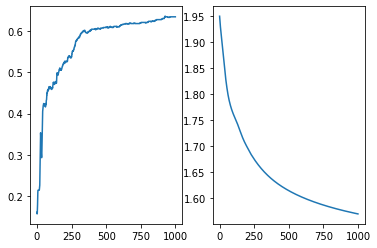

In [245]:
x_plt = np.linspace(0, n_epochs-1, n_epochs, endpoint=True, dtype=int)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x_plt, acc_history)
ax2.plot(x_plt, loss_history)